In [254]:
import pickle
import h2o
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from fancyimpute import MICE as MICE
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

from fancyimpute import MICE


%matplotlib inline

In [125]:
h2o.init(nthreads=-1, min_mem_size="2G", max_mem_size = "6G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,12 hours 5 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,"21 days, 17 hours and 22 minutes"
H2O cluster name:,H2O_from_python_songlin_b3n9iz
H2O cluster total nodes:,1
H2O cluster free memory:,4.650 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [126]:
# This cell is just about making things look nice

# Make plots bigger by default.
# Has to occur after the %matplotlib inline in a different cell. Known issue
plt.rc('figure', figsize=(16.0, 10.0))
plt.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

## Import training data

In [350]:
with open('./data/processed/X_train.pkl', 'rb') as picklefile:
    X_train = pickle.load(picklefile)

In [128]:
with open('./data/processed/y_train.pkl', 'rb') as picklefile:
    y_train = pickle.load(picklefile)

In [129]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14927 entries, 0 to 14926
Data columns (total 16 columns):
id                         14927 non-null object
date_account_created       14927 non-null object
timestamp_first_active     14927 non-null object
date_first_booking         6259 non-null object
gender                     14927 non-null object
age                        8756 non-null float64
signup_method              14927 non-null object
signup_flow                14927 non-null int64
language                   14927 non-null object
affiliate_channel          14927 non-null object
affiliate_provider         14927 non-null object
first_affiliate_tracked    14500 non-null object
signup_app                 14927 non-null object
first_device_type          14927 non-null object
first_browser              14927 non-null object
splitseed                  14927 non-null float64
dtypes: float64(2), int64(1), object(13)
memory usage: 1.8+ MB


In [130]:
X_train.set_index('id', inplace=True)

In [133]:
y_train = pd.DataFrame(y_train, columns=['country'], index=X_train.index)

## Deal with wrong values and missing values

In [136]:
# Impute wrong age values (<5 or >100) as avg age
X_age_notnull = X_train[X_train['age'].notnull() & ((X_train['age'] > 10) & (X_train['age'] < 100))]
print (X_age_notnull.shape[0])

X_age_null = X_train[X_train['age'].isna() | (X_train['age'] <= 10) | (X_train['age'] >= 100)]
print (X_age_null.shape[0])

#mean_age = np.mean(X_age_notnull[(X_age_notnull['age']>5) & (X_age_notnull['age']<100)]['age'])
# X_train.loc[(X_train['age']<5) | (X_train['age']>100), 'age'] = mean_age
#X_age_notnull.loc[(X_age_notnull['age']<5) | (X_age_notnull['age']>100), 'age'] = mean_age

8585
6342


In [137]:
# Drop the irrelevant columns
cols_to_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'splitseed']
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_age_notnull.drop(cols_to_drop, axis=1, inplace=True)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Predict missing age values

In [190]:
y_age = (pd.DataFrame(X_age_notnull['age'], columns=['age']))
X_age = deepcopy(X_age_notnull)
X_age.drop('age', axis=1, inplace=True)

In [191]:
df_age = pd.concat([X_age, y_age], axis=1)

In [192]:
h2o_age = h2o.H2OFrame(df_age)

Parse progress: |█████████████████████████████████████████████████████████| 100%


**Apply h2o model**

In [193]:
train, valid = h2o_age.split_frame([0.8], seed=1234)
X = h2o_age.col_names[:-1]
y = h2o_age.col_names[-1]

In [194]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_age_v1",
    score_each_iteration=True,
    seed=1000000)

In [195]:
hyper_parameters = {'ntrees':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    'max_depth':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [196]:
criteria = {"strategy": "RandomDiscrete", 
            "stopping_rounds": 10,
            "stopping_tolerance": 0.00001,
            "stopping_metric": "MSE"}

In [197]:
grid_search = H2OGridSearch(model = rf_v1, 
                            hyper_params = hyper_parameters,
                            search_criteria = criteria)

In [198]:
grid_search.train(X,
                  y,
                  training_frame = train,
                  validation_frame = valid)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [71]:
# rf_v1.train(X, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [204]:
sorted_grid = grid_search.get_grid(sort_by='mse', decreasing=False)
best_max_depth  = sorted_grid.sorted_metric_table()['max_depth'][0]
best_ntrees     = sorted_grid.sorted_metric_table()['ntrees'][0]

best_mse        = sorted_grid.sorted_metric_table()['mse'][0]
print('Best mse...........', best_mse)

other_mse        = sorted_grid.sorted_metric_table()['mse'][2]
print('Other mse...........', other_mse)

Best mse........... 126.26994438104408
Other mse........... 126.45057576506505


In [205]:
print (best_ntrees)
print (best_max_depth)

100
10


In [206]:
## Fit the best model on the whole training set!!

best_rf = H2ORandomForestEstimator(
    model_id = "best_rf",
    ntrees = int(best_ntrees),
    max_depth = int(best_max_depth),
    stopping_rounds = 5,
    score_each_iteration = True,
    seed = 1000000)

best_rf.train(X, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [207]:
y_age_predict = best_rf.predict(valid)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [208]:
y_age_valid = valid[:,-1]

In [173]:
best_rf.cross_validation_metrics_summary

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  best_rf


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.07903277793414012
RMSE: 0.28112768973215735
MAE: 0.2233326536581192
RMSLE: 0.061098992926262474
Mean Residual Deviance: 0.07903277793414012

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.08293834137751381
RMSE: 0.28799017583506875
MAE: 0.2303275152437635
RMSLE: 0.06287095431260663
Mean Residual Deviance: 0.08293834137751381
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-08-01 21:00:54,0.035 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-08-01 21:00:54,0.079 sec,1.0,0.2942450,0.2319714,0.0865801,0.3012892,0.2391198,0.0907752
,2018-08-01 21:00:54,0.121 sec,2.0,0.2926760,0.2307361,0.0856592,0.2930208,0.2335911,0.0858612
,2018-08-01 21:00:54,0.166 sec,3.0,0.2917792,0.2301876,0.0851351,0.2920070,0.2331309,0.0852681
,2018-08-01 21:00:54,0.208 sec,4.0,0.2884073,0.2278292,0.0831788,0.2919013,0.2331808,0.0852064
---,---,---,---,---,---,---,---,---,---
,2018-08-01 21:00:55,0.966 sec,22.0,0.2812264,0.2234099,0.0790883,0.2878967,0.2303059,0.0828845
,2018-08-01 21:00:55,1.008 sec,23.0,0.2812872,0.2234019,0.0791225,0.2880082,0.2304365,0.0829487
,2018-08-01 21:00:55,1.040 sec,24.0,0.2811932,0.2233041,0.0790696,0.2879436,0.2303300,0.0829115
,2018-08-01 21:00:55,1.067 sec,25.0,0.2811128,0.2232508,0.0790244,0.2879624,0.2303157,0.0829224



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
first_browser,476.6505432,1.0,0.2675826
affiliate_provider,250.0258636,0.5245475,0.1403598
affiliate_channel,225.3243713,0.4727245,0.1264928
language,181.1167297,0.3799780,0.1016755
first_affiliate_tracked,160.5339966,0.3367960,0.0901207
first_device_type,146.2531586,0.3068352,0.0821038
gender,115.1257935,0.2415308,0.0646294
signup_flow,97.5757065,0.2047112,0.0547772
signup_method,67.9700317,0.1425993,0.0381571
signup_app,60.7450333,0.1274414,0.0341011


<bound method ModelBase.cross_validation_metrics_summary of >

In [209]:
print ('RMSE of age imputation via h2o model is {}'.format(np.sqrt(((y_age_predict - y_age_valid)**2).mean())))

RMSE of age imputation via h2o model is [  11.254]


In [187]:
df_y_pred = np.exp(y_age_predict.as_data_frame())
df_y_actual = np.exp(y_age_valid.as_data_frame())

In [210]:
df_y_pred = (y_age_predict.as_data_frame())
df_y_actual = (y_age_valid.as_data_frame())

In [201]:
df_y_pred.values

array([[  39.959],
       [  35.535],
       [  32.453],
       ...,
       [  38.287],
       [  31.299],
       [  35.535]])

In [202]:
np.sqrt(np.mean((df_y_pred.values - df_y_actual.values)**2))

11.310991420736338

Text(0,0.5,'Predicted age')

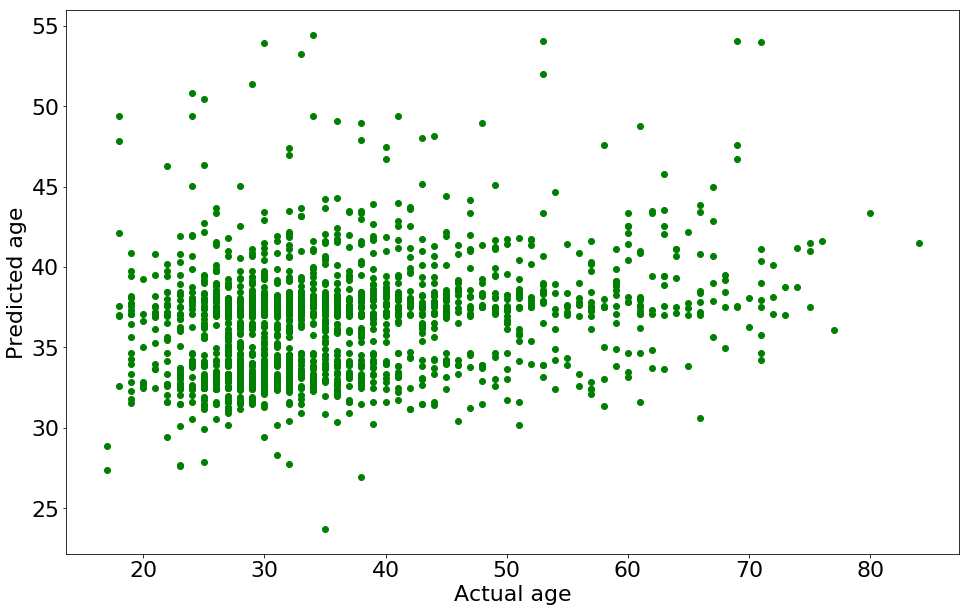

In [211]:
plt.plot(df_y_actual, df_y_pred, 'go')
plt.xlabel('Actual age')
plt.ylabel('Predicted age')

## Predict with random Forest

In [212]:
y_age = pd.DataFrame(X_age_notnull['age'], columns=['age'])
X_age = deepcopy(X_age_notnull)
X_age.drop('age', axis=1, inplace=True)

In [213]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, train_size=0.25)

In [220]:
def custom_dummify(df, threshold, train_cols=None):
    df_concat = pd.DataFrame()
    df_noncat = df.select_dtypes(exclude='object')
    # print(df_noncat.shape)
    df = df.select_dtypes(include='object')
    
    all_cols = []
        
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in levels.index:
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)

        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        if (train_cols != None):
            for x in cols_to_keep:
                if x not in train_cols:
                    cols_to_keep.remove(x)
        all_cols.extend(cols_to_keep)
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df_concat = pd.concat([df_concat, df_unify], axis=1)
    # print(df_concat.shape)
    return pd.concat([df_noncat, df_concat], axis=1 ), all_cols

In [221]:
X_age_train_dummy, train_cols = custom_dummify(X_age_train, 0.01)

In [216]:
# Create Gridsearch

param_grid = [{
        'max_depth': np.linspace(1, 100, 5).astype('int'),
        'n_estimators': np.linspace(50, 100, 5).astype('int')
    }]

RF = RandomForestRegressor()
grid = GridSearchCV(RF, cv=5, n_jobs=-1, param_grid=param_grid)

grid.fit(X_age_train_dummy, y_age_train)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validat

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validat

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validat

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validat

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validat

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': array([ 50,  62,  75,  87, 100]), 'max_depth': array([  1,  25,  50,  75, 100])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [271]:
# Store the best model
with open('./data/model/age_prediction_sk.pkl', 'wb') as picklefile:
    pickle.dump(grid, picklefile)

In [19]:
with open('./data/model/age_prediction_sk.pkl', 'rb') as picklefile:
    grid = pickle.load(picklefile)

In [223]:
X_age_test_dummy, _ = custom_dummify(X_age_test, 0.01, train_cols)
y_pred_test = grid.predict(X_age_test_dummy)
rmse = np.sqrt(np.mean((y_pred_test[:,np.newaxis]-y_age_test)**2))
print ('RMSE of age imputation via random forest is {}'.format(rmse))

RMSE of age imputation via random forest is age    11.484188
dtype: float64


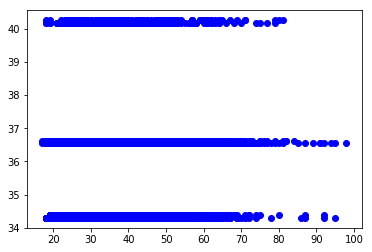

In [226]:
plt.plot(y_age_test, y_pred_test, 'bo')

**Note the RMSE from RF model is higher than h2o model, thus we will use h2o model to predict the age

## Use MICE to impute age

In [312]:
X_mice = deepcopy(X_age_notnull)

In [313]:
random.seed(1234)
na_index = random.sample(range(X_mice.shape[0]), int(X_mice.shape[0]*0.3))

In [314]:
X_mice['age'] = np.log(X_mice['age'])

In [315]:
X_mice.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,
036qtdh8u5,MALE,3.332205,basic,0,en,direct,direct,omg,Web,Mac Desktop,Chrome
h9rli9yvhx,FEMALE,3.332205,basic,0,en,direct,direct,omg,Web,Mac Desktop,Chrome
pporitxzzw,MALE,3.433987,facebook,0,en,remarketing,google,linked,Web,Mac Desktop,Safari
yp8cmoln1o,MALE,3.891820,facebook,0,en,sem-non-brand,google,omg,Web,Windows Desktop,IE
1lflm3c81h,MALE,3.218876,facebook,3,en,sem-brand,google,omg,Web,Windows Desktop,IE


In [316]:
X_mice.iloc[na_index, 1] = np.NAN

In [317]:
X_mice_dummify, _ = custom_dummify(X_mice, 0.01)

In [318]:
X_mice.shape

(8585, 11)

In [319]:
df_imput = MICE(n_imputations=200, impute_type='col', verbose=False).complete(X_mice_dummify.as_matrix())

In [321]:
df_imputed = pd.DataFrame(df_imput)

In [325]:
imputed = np.exp(df_imputed.iloc[na_index,0])

In [339]:
actual = X_age_notnull.iloc[na_index,1]

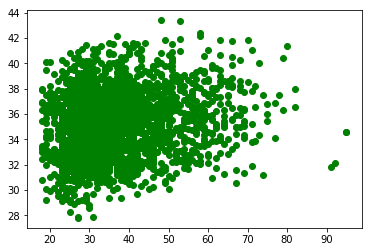

In [341]:
plt.plot(actual, imputed, 'go')

In [342]:
np.sqrt(np.mean((actual.values - imputed.values)**2))

11.136609323901409

### Predict age for entries without valid age info

In [352]:
X_train_dummify, _ = custom_dummify(X_train, 0.01)
df_imput = MICE(n_imputations=200, impute_type='col', verbose=False).complete(X_train_dummify.as_matrix())

In [353]:
df_imputed = pd.DataFrame(df_imput)
#X_train['age'] = df_imputed.iloc[:,0]

In [355]:
X_train['age'] = df_imputed.iloc[:,0].values

In [356]:
X_train.head(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,splitseed
0,ppr8sr6z33,2014-06-15,20140615004156,None,-unknown-,21.617223,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,0.478538
1,eiwzl341qa,2013-12-16,20131216153039,None,-unknown-,49.829503,basic,25,en,direct,direct,linked,iOS,Mac Desktop,Safari,0.629914
2,lor9srems2,2014-04-07,20140407202112,None,-unknown-,36.694278,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,0.180260
3,uk2031aezt,2014-01-11,20140111154240,None,-unknown-,76.955883,basic,25,en,direct,direct,untracked,iOS,iPad,-unknown-,0.561323
4,q7k5aflli0,2013-06-01,20130601223530,None,-unknown-,61.827731,basic,0,en,sem-non-brand,vast,omg,Web,Windows Desktop,Firefox,0.244916
5,eswm7wig2e,2014-03-04,20140304032206,None,-unknown-,65.709658,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,0.687217
6,036qtdh8u5,2014-03-08,20140308024141,None,MALE,28.000000,basic,0,en,direct,direct,omg,Web,Mac Desktop,Chrome,0.601401
7,8692718hr3,2013-04-22,20130422005654,None,MALE,63.778243,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,0.531830
8,iblg556q1g,2014-03-26,20140326194011,None,-unknown-,46.150304,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Chrome,0.375255
9,l6m0ygh6wi,2013-12-01,20131201204738,None,MALE,59.625217,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,0.126706


In [357]:
## Store the imputed data for further processing

with open('./data/processed/X_train_age_imputed.pkl', 'wb') as picklefile:
    pickle.dump(X_train,picklefile)
